In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import style, cm
from sklearn.linear_model import LinearRegression
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
df = pd.read_csv("___")[["time","height"]]
df["time"] = pd.to_datetime(df["time"], unit="s") #block header is actually seconds since epoch


c:\users\aman\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#1st block: reward was 50 BTC
#after every 210K * 'i' blocks, reward is 50/2^i
#'i' for nth block (height=n) is hence n/210K
#reward is thus 50/(2^(height/210K))
df["reward"] = 50/(2**np.floor(df["height"]/210000))


In [4]:
df["total"] = df["reward"].cumsum() #total number of BTC in existence

In [5]:
#PlanB removes all data that corresponds to 1 million BTC being lost
df = df.drop(df[df.total <= 1000000].index)

In [6]:
df.set_index("time", inplace = True)

In [7]:
monthly = df.resample("1M").first() #divides into months, and shows 1st in a month

In [8]:
monthly[:3] #initial block reward was 50

,height,reward,total
time,,,
2009-07-31,20001,50.0,1000100.0
2009-08-31,20376,50.0,1018850.0
2009-09-30,21940,50.0,1097050.0


In [9]:
monthly[-3:] #current block reward is 6.25


,height,reward,total
time,,,
2021-03-31,672628,6.25,18641431.25
2021-04-30,677223,6.25,18670150.00
2021-05-31,681296,6.25,18695606.25


In [10]:
monthly["blockspm"] = monthly.height.diff()
monthly = monthly[monthly.index < "2019-03-01"]
monthly = monthly[monthly.index > "2009-12-01"]

In [11]:
halving = [0]
for i in range(1,len(monthly)):
    halving.append(monthly.reward[i]-monthly.reward[i-1])

In [12]:
monthly[35:37]

,height,reward,total,blockspm
time,,,,
2012-11-30,205919,50.0,10296000.0,4608.0
2012-12-31,210350,25.0,10508775.0,4431.0


In [13]:
monthly[79:81]

,height,reward,total,blockspm
time,,,,
2016-07-31,418723,25.0,15718100.0,4465.0
2016-08-31,423088,12.5,15788612.5,4365.0


In [14]:
monthly[110:]
#May 2020 is 110+15 months after this = 125

,height,reward,total,blockspm
time,,,,
2019-02-28,560984,12.5,17512312.5,4525.0


In [15]:
halving_months = [i for i,val in enumerate(halving) if val<0]
#halving occurs in month 36 and 80
#3rd halving was May, 2020 and that would be another 45 months

In [16]:
halving_months.append(125)

In [17]:
#so what is stock? --> total, which is cumsum()
#what is flow? --> current reward being given * blocks per year

#for last month
stock = monthly.total[-1]
flow = monthly.reward[-1] * (monthly.height[-1]-monthly.height[-2])*12
stock, flow, stock/flow

(17512312.5, 678750.0, 25.80082872928177)

Text(0.5, 1.0, 'S2F values')

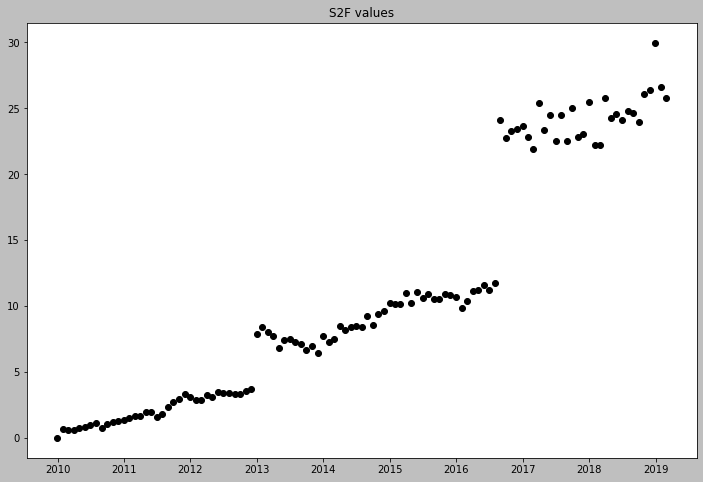

In [84]:
def get_s2f(i):
    stock = monthly.total[i]
    flow = monthly.reward[i] * (monthly.height[i]-monthly.height[i-1])*12
    return stock/flow

s2f = [0]
for i in range(1,len(monthly)):
    s2f.append(get_s2f(i))
    
plt.scatter(monthly.index, s2f)
plt.title("S2F values")

In [19]:
#price = mcap * no_of_btc
price_data = pd.read_csv("___")[["Date", "Value"]]
price_data["Date"] = pd.to_datetime(price_data["Date"])
#get price on some particular dates only
price_data.set_index("Date", inplace = True)
dates = list(monthly.index.strftime("%Y-%m-%d"))


In [20]:
dates[0:4]

['2009-12-31', '2010-01-31', '2010-02-28', '2010-03-31']

In [21]:
prices = []
for d in dates:
    prices.append(list(price_data[d].Value)[0])

In [22]:
monthly.total[dates[0]]

1422150.0

In [88]:
len(monthly), len(prices)
mcap=[]
for i in range(len(monthly)):
    mcap.append(monthly.total[i]*prices[i])

In [24]:
s2f_suppgr = 1/(monthly.total.pct_change()*12)
#this argument states that SF = 1 / supply growth rate
#supply growth rate is simply rate at which supply grows, i.e. % change each month * 12 for a year

In [25]:
plt.rcParams['figure.figsize'] = [12, 10]


In [27]:

#fig, ax = plt.subplots()
#ax.semilogy(monthly.index, s2f, label="S2F")
#ax.semilogy(price_data.index, price_data.Value, label = "BTC/USD")
#plt.yscale('log', subsy=[1])
#ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
#ax.legend()

In [31]:
prediction = [0.4*(x**3) for x in s2f]

In [34]:
prediction_planb = [0.4*(x**3) for x in s2f]

In [35]:
new_blockspm=[]
for x in monthly.blockspm:
    if(x>6000):
        x=6000
    if(x<4000):
        x=4000
    new_blockspm.append(x)

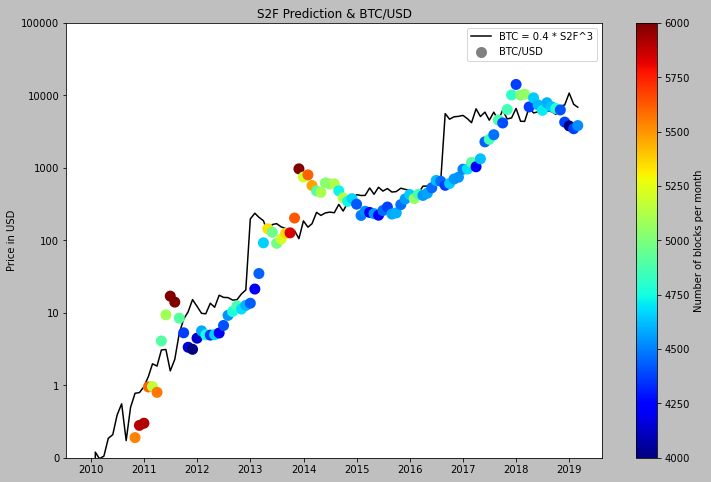

In [36]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use("grayscale")
fig, ax = plt.subplots()
im = ax.scatter(monthly.index, prices, c = new_blockspm, cmap = cm.jet, lw=5, alpha=1, zorder=5, label="BTC/USD")
ax.plot(monthly.index, prediction, c="black", label = "BTC = 0.4 * S2F^3")
plt.yscale("log", subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Number of blocks per month")
plt.ylabel("Price in USD")
plt.ylim([0.1, 100000])
plt.title("S2F Prediction & BTC/USD")
plt.legend()
plt.show()

In [37]:
halving_months
tthalving = []
for i in range(0,35):
    tthalving.append(35-i)
tthalving.append(0)
for i in range(0,43):
    tthalving.append(43-i)
tthalving.append(0)
for i in range(0,44):
    tthalving.append(44-i)

tthalving = tthalving[:111]
print(len(tthalving))
monthly.reward[35]

111


50.0

In [95]:
mcap = [x+0.01 for x in mcap]
prices = [x+0.01 for x in prices]
s2f = [x+0.01 for x in s2f]

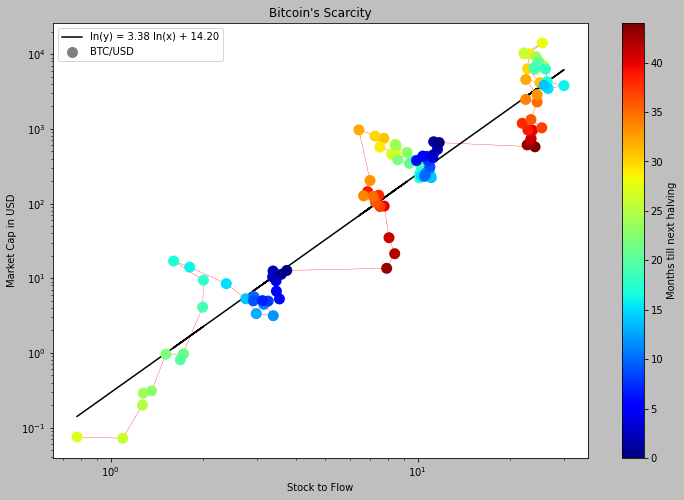

In [98]:
X = np.array(np.log(s2f)).reshape(-1,1) #makes it a list of lists incase we had multiple linear regression
y = np.array(np.log(prices)) #first 8 mcap values are 0, can't log it

#now X and y are how they look on a log-log chart
reg = LinearRegression().fit(X,y)

#remember plt plots on a linear axis and our X and y have been "logged"

fig, ax = plt.subplots()
im1 = ax.loglog(s2f[8:], prices[8:], "r-", linewidth=0.3)

#tthalving has been calculated as time to next halving
im2 = ax.scatter(s2f[8:], prices[8:], c = tthalving[8:], cmap = cm.jet, lw=5, alpha=1, zorder=5, label="BTC/USD")

#remember plt plots on a linear axis and our X and y have been "logged" so we gotta exponentiate
plt.plot(np.exp(X)[8:], np.exp(reg.predict(X)[8:]), label="ln(y) = 3.38 ln(x) + 14.20")

cbar = fig.colorbar(im2, ax=ax)
cbar.ax.set_ylabel("Months till next halving")
#plt.ylim([100000, 1000000000000])
plt.title("Bitcoin's Scarcity")
plt.legend()
plt.xlabel("Stock to Flow")
plt.ylabel("Market Cap in USD")
plt.show()

In [99]:
reg.predict([[0]]), reg.predict([[1]])-reg.predict([[0]])

(array([-1.21688119]), array([2.92527793]))

In [41]:
def func(x, p1):
    return p1 * (x**3)

In [42]:
from scipy.optimize import curve_fit

In [61]:

ydata = np.log(prices[8:])
xdata = np.log(s2f[8:])

#extended_dates = pd.date_range(df["Date"].iloc[0], "2023-01-01")

#extract optimal coefficients using curve fit
popt, pcov = curve_fit(func, xdata, ydata, p0=(1))

#try to get ydata from xdata and function
#popt has coefficients, pcov has covariances between them
print(popt)

[0.28523008]


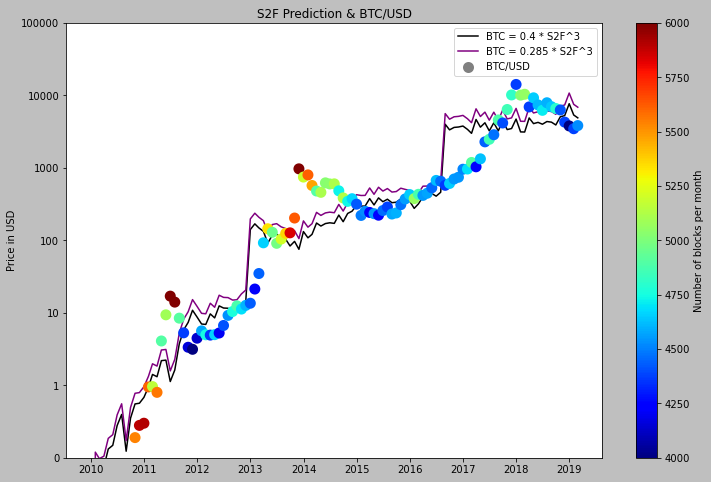

In [62]:
prediction_self = [popt[0]*(x**3) for x in s2f]

plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use("grayscale")
fig, ax = plt.subplots()
im = ax.scatter(monthly.index, prices, c = new_blockspm, cmap = cm.jet, lw=5, alpha=1, zorder=5, label="BTC/USD")
ax.plot(monthly.index, prediction_self, c="black", label = "BTC = 0.4 * S2F^3")
ax.plot(monthly.index, prediction_planb, c="purple", label = "BTC = 0.285 * S2F^3")
plt.yscale("log", subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Number of blocks per month")
plt.ylabel("Price in USD")
plt.ylim([0.1, 100000])
plt.title("S2F Prediction & BTC/USD")
plt.legend()
plt.show()